In [1]:
from pathlib import Path
import json
import os
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import contextily as ctx

In [77]:
DATA_DIR = Path("./data")

In [83]:
def load_json(filepath):
    with open(filepath) as f:
        return json.load(f)

def get_speedband(filepath, link_id):
    jjson = load_json(filepath)
    for link in jjson:
        if link["LinkID"] == str(link_id):
            return link["SpeedBand"]

def filename_to_time(filename):
    time_string = filename.split(".")[0]
    date_time = datetime.strptime(time_string, "%H:%M:%S")
    return date_time
        
def get_speedbands(daypath, link_id):
    file_list = os.listdir(daypath)
    file_list.sort()
    time_list = []
    speedband_list = []
    for file in file_list:
        time = filename_to_time(file)
        time_list.append(time)
        speedband = get_speedband(daypath/file, link_id)
        speedband_list.append(speedband)
    return time_list, speedband_list

def plot_speedbands(daypath, link_id):
    times, speedbands = get_speedbands(daypath, link_id)
    plt.plot(times, speedbands, label = daypath)
    ax = plt.gca()
    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed Band")
    ax.set_title(link_id)
    ax.legend()
    plt.show()
    
def plot_all_speedbands(datadir, day, link_id):
    datelist = os.listdir(datadir)
    datelist = [date for date in datelist if date.startswith(day)]
    for date in datelist:
        times, speedbands = get_speedbands(datadir/date, link_id)
        plt.plot(times, speedbands, label = date)
    ax = plt.gca()
    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed Band")
    ax.set_title(link_id)
    ax.legend()
    plt.show()
    
def loc_to_linestring(loc):
    coordArr = loc.split()
    coordArr = [float(coord) for coord in coordArr]
    return LineString([coordArr[1::-1], coordArr[3:1:-1]])

CATEGORIES = {
    "A":("Expressway", "tab:cyan"),
    "B":("Major Arterial Road", "tab:red"),
    "C":("Arterial Road", "tab:blue"),
    "D":("Minor Arterial Road", "tab:green"),
    "E":("Small Road", "tab:olive"),
    "F":("Slip Road", "tab:purple"),
}

def plot_map(filepath, links=[]):
    df = pd.read_json(filepath)
    linestrings = df["Location"].apply(loc_to_linestring)
    gdf = gpd.GeoDataFrame(df, geometry=linestrings, crs="EPSG:4326")
    gdf = gdf.to_crs('EPSG:3857')
    fig, ax = plt.subplots(figsize=(10, 10))
    if len(links) == 0:
        for k, v in CATEGORIES.items():
            trunc = gdf[gdf["RoadCategory"] == k]
            if len(trunc) != 0:
                ax = trunc.plot(ax=ax, color=v[1], label=v[0])
    else:
        cmap = plt.cm.get_cmap("brg", len(links)+1)
        for i in range(len(links)):
            trunc = gdf[gdf["LinkID"] == links[i]]
            if len(trunc) != 0:
                ax = trunc.plot(ax=ax, label=links[i], color=cmap(i))
        gdf[~gdf["LinkID"].isin(links)].plot(ax=ax, color=cmap(len(links)))

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    ctx.add_basemap(ax)

In [91]:
LINK_1 = 103072100
LINK_2 = 103075472
LINK_3 = 104002152

# Daily Trends

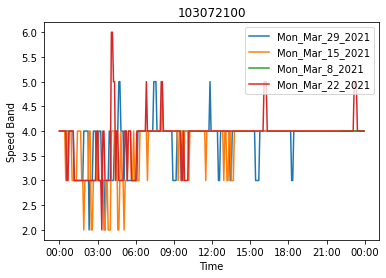

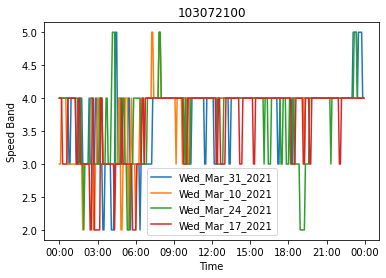

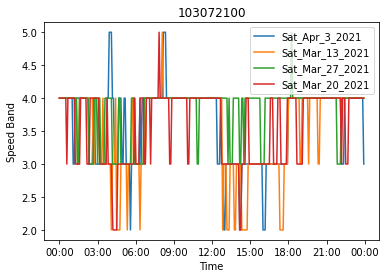

In [93]:
plot_all_speedbands(DATA_DIR, "Mon", TEST_1)
plot_all_speedbands(DATA_DIR, "Wed", TEST_1)
plot_all_speedbands(DATA_DIR, "Sat", TEST_1)

# Link Proximity

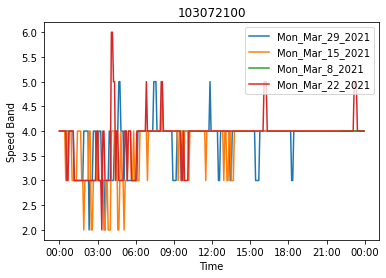

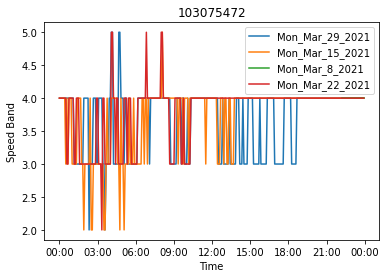

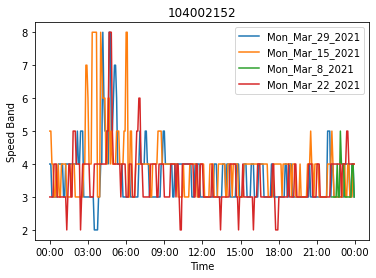

In [94]:
plot_all_speedbands(DATA_DIR, "Mon", TEST_1)
plot_all_speedbands(DATA_DIR, "Mon", TEST_2)
plot_all_speedbands(DATA_DIR, "Mon", TEST_3)

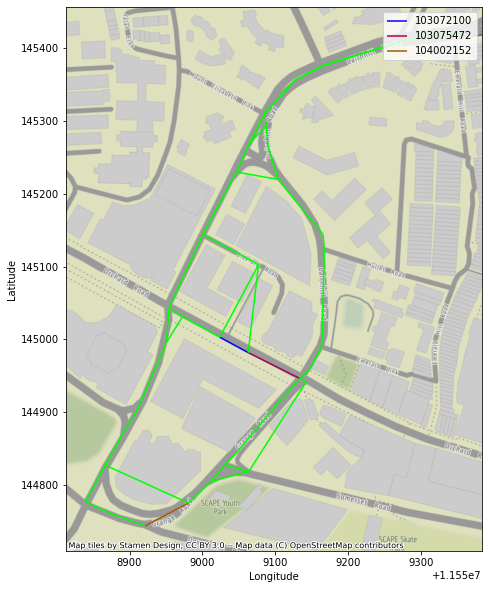

In [95]:
plot_map(DATA_DIR/"Fri_Apr_2_2021"/"00:00:10.json", links=[TEST_1, TEST_2, TEST_3])